In [ ]:
%matplotlib inline
from __future__ import division # Give true division instead of floor division
import numpy as np # Input numpy
from numpy.random import rand # Input random number generator from numpy
import matplotlib.pyplot as plt # Input matplotlib

In [ ]:
# Plot the configuration (no need to run it if don't need the plot!) 
def plotconfig(config, iT):
    
    f = plt.figure(figsize=(12, 12), dpi=80);  
    X, Y = np.meshgrid(range(N), range(N))
   
    sp =  f.add_subplot(1, 2, 1) 
    plt.setp(sp.get_yticklabels(), visible=True)
    plt.setp(sp.get_xticklabels(), visible=True)      
    plt.pcolormesh(X, Y, config[0], cmap=plt.cm.RdBu)  
    plt.title('T=%f'%iT); 
    plt.axis('tight') 
    plt.gca().set_aspect('equal')
    
    sp =  f.add_subplot(1, 2, 2) 
    plt.setp(sp.get_yticklabels(), visible=True)
    plt.setp(sp.get_xticklabels(), visible=True)    
    plt.pcolormesh(X, Y, config[1], cmap=plt.cm.RdBu);
    plt.title('T=%f'%iT); 
    plt.axis('tight')
    plt.gca().set_aspect('equal')
    
    # blue color - 1 , red color - -1
    
    # plt.show()

In [ ]:
# The model we simulate: H = -β Sum[σ_{1,i} σ_{1,j}] -β Sum [σ_{2,i} σ_{2,j}] - α Sum[σ_{1,i} σ_{1,j} σ_{2,i'} σ_{2,j'}]
# We will set β<<α

In [1]:
%matplotlib inline
from __future__ import division # Give true division instead of floor division
import numpy as np # Input numpy
from numpy.random import rand
import matplotlib.pyplot as plt

In [25]:
#----------------------------------------------------------------------
##  BLOCK OF FUNCTIONS USED IN THE MAIN CODE
#----------------------------------------------------------------------

# Generate a random initial state (hot start) for both layers - Array dim is 2xNxN

def initialstate(N):   
    state = np.random.choice([-1,1], size=(2,N,N))
    return state

# Generate an all up-spin initial state (cold start) for both layers - Array dim is 2xNxN

def coldstate(N):
    state = np.ones((2,N,N))
    return state

# Monte Carlo move using Metropolis algorithm
# beta describes the usual spin-spin Ising interaction
# alpha describes the 4-spin interaction

def mcmove(config, alpha, beta, T):
    
    # Need to scan the whole lattice for ensuring detailed balance
    for k in range (2):
        for i in range(N):
            for j in range(N):
                
                layer = np.random.choice([0,1])
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[layer,a, b]
                
                # The two-spin interaction
                nb2 = config[layer,(a+1)%N,b] + config[layer,(a-1)%N,b] + config[layer,a,(b+1)%N]  + config[layer,a,(b-1)%N]
               
                # The four-spin interaction
                if layer==0:
                    nb4 = (config[0,(a-1)%N,b]*config[1,(a-1)%N,b]*config[1,(a-1)%N,(b+1)%N]
                           + config[0,(a+1)%N,b]*config[1,a,b]*config[1,a,(b+1)%N])
                else:
                    nb4 = (config[0,a,(b-1)%N]*config[0,(a+1)%N,(b-1)%N]*config[1,a,(b-1)%N]
                           + config[0,a,b]*config[0,(a+1)%N,b]*config[1,a,(b+1)%N])
                
                cost = 2*s*(beta*nb2+alpha*nb4) # energy change in flipping the random spin
                
                if cost < 0: # accept the flip if energy is decreased
                    s *= -1
                elif rand() < np.exp(-cost/T): # accept with Boltzmann weight if energy is increased
                    s *= -1
                config[layer,a, b] = s
                
    return config

# Energy of a given configuration

def calcEnergy(config,alpha,beta):
    
    energy = 0
    
    for k in range (2):
        for i in range(N):
            for j in range(N):
                S = config[k,i,j]
                nb2 = config[k,(i+1)%N, j] + config[k,i,(j+1)%N] + config[k,(i-1)%N, j] + config[k,i,(j-1)%N]
                
                if k==0:
                    nb4=config[0, i, j]*config[0,(i+1)%N,j]*config[1, i, j]*config[1,i,(j+1)%N]
                else:
                    nb4=0
                    
                energy += -beta*nb2*S/2-alpha*nb4
    return energy

# Magnetization for each layer and 4-cross spin of a given configuration
def calcMag(config):
    mag1 = np.sum(config[0]);
    mag2 = np.sum(config[1]);
    
    mag4 = 0
    for i in range(N):
        for j in range(N):
            mag4 += config[0, i, j]*config[1, i, j]*config[0,(i+1)%N,j]*config[1,i,(j+1)%N]
    
    return mag1, mag2, mag4

In [26]:
## change these parameters for a smaller (faster) simulation 
na  = 50        #  number of alpha points
N       = 32        #  size of the lattice for each layer, N x N
eqSteps = 700       #  number of MC sweeps for equilibration
mcSteps = 700       #  number of MC sweeps for calculation

Tlist = np.linspace(0.01,2, na); # for α=O(1) 

# Tlist = np.linspace(0.1,20, na); # for α=O(10) 
Elist = np.zeros(na);

M1list, M2list, M4list = np.zeros(na), np.zeros(na), np.zeros(na);

Clist = np.zeros(na); # specific heat
Xlist = np.zeros(na); # effective suspectability for 4-spins

# divide by number of samples, and by system size to get intensive values
n1 = 1.0/(mcSteps*2*N*N); 
n2= 1.0/(mcSteps*mcSteps*2*N*N); 

In [27]:
#----------------------------------------------------------------------
#  MAIN PART OF THE CODE
# beta/alpha = 10^(-10)
#----------------------------------------------------------------------
for aa in range(na):
    E1 = E2 = 0 # energy, energy squared
    M1 = M2 = 0 # magnetization, SiSj
    M4 = M4sq = 0 # 4-spin product, and squared
    
    config = initialstate(N) #random initial state 
    # config = coldstate(N)
    
    betavalue = 10**(-5) # Value for the Ising interaction
    alphavalue = 2. # Value for the 4 spin interaction
    
    iT = Tlist[aa]; # Effective temperature

    for i in range(eqSteps):         # equilibrate
        mcmove(config, alphavalue, betavalue, iT)           # Monte Carlo moves

    for i in range(mcSteps):
        mcmove(config, alphavalue, betavalue, iT)   
        
        Ene = calcEnergy(config,alphavalue,betavalue)     # calculate the energy
        E1 = E1 + Ene
        
        Mag = calcMag(config)        # calculate the magnetisation for each layer and the 4-spin
        M1 = M1 + Mag[0]
        M2 = M2 + Mag[1]
        M4 = M4 + Mag[2]
        
        M4sq = M4sq + Mag[2]*Mag[2] 
        E2 = E2 + Ene*Ene

    Elist[aa] = n1*E1
    Clist[aa] = (n1*E2 - n2*E1*E1)/(iT*iT)
    
    M1list[aa] = 2*n1*M1
    M2list[aa] = 2*n1*M2
    
    M4list[aa] = 2*n1*M4
    Xlist[aa] = (2*n1*M4sq - 2*n2*M4*M4)/iT

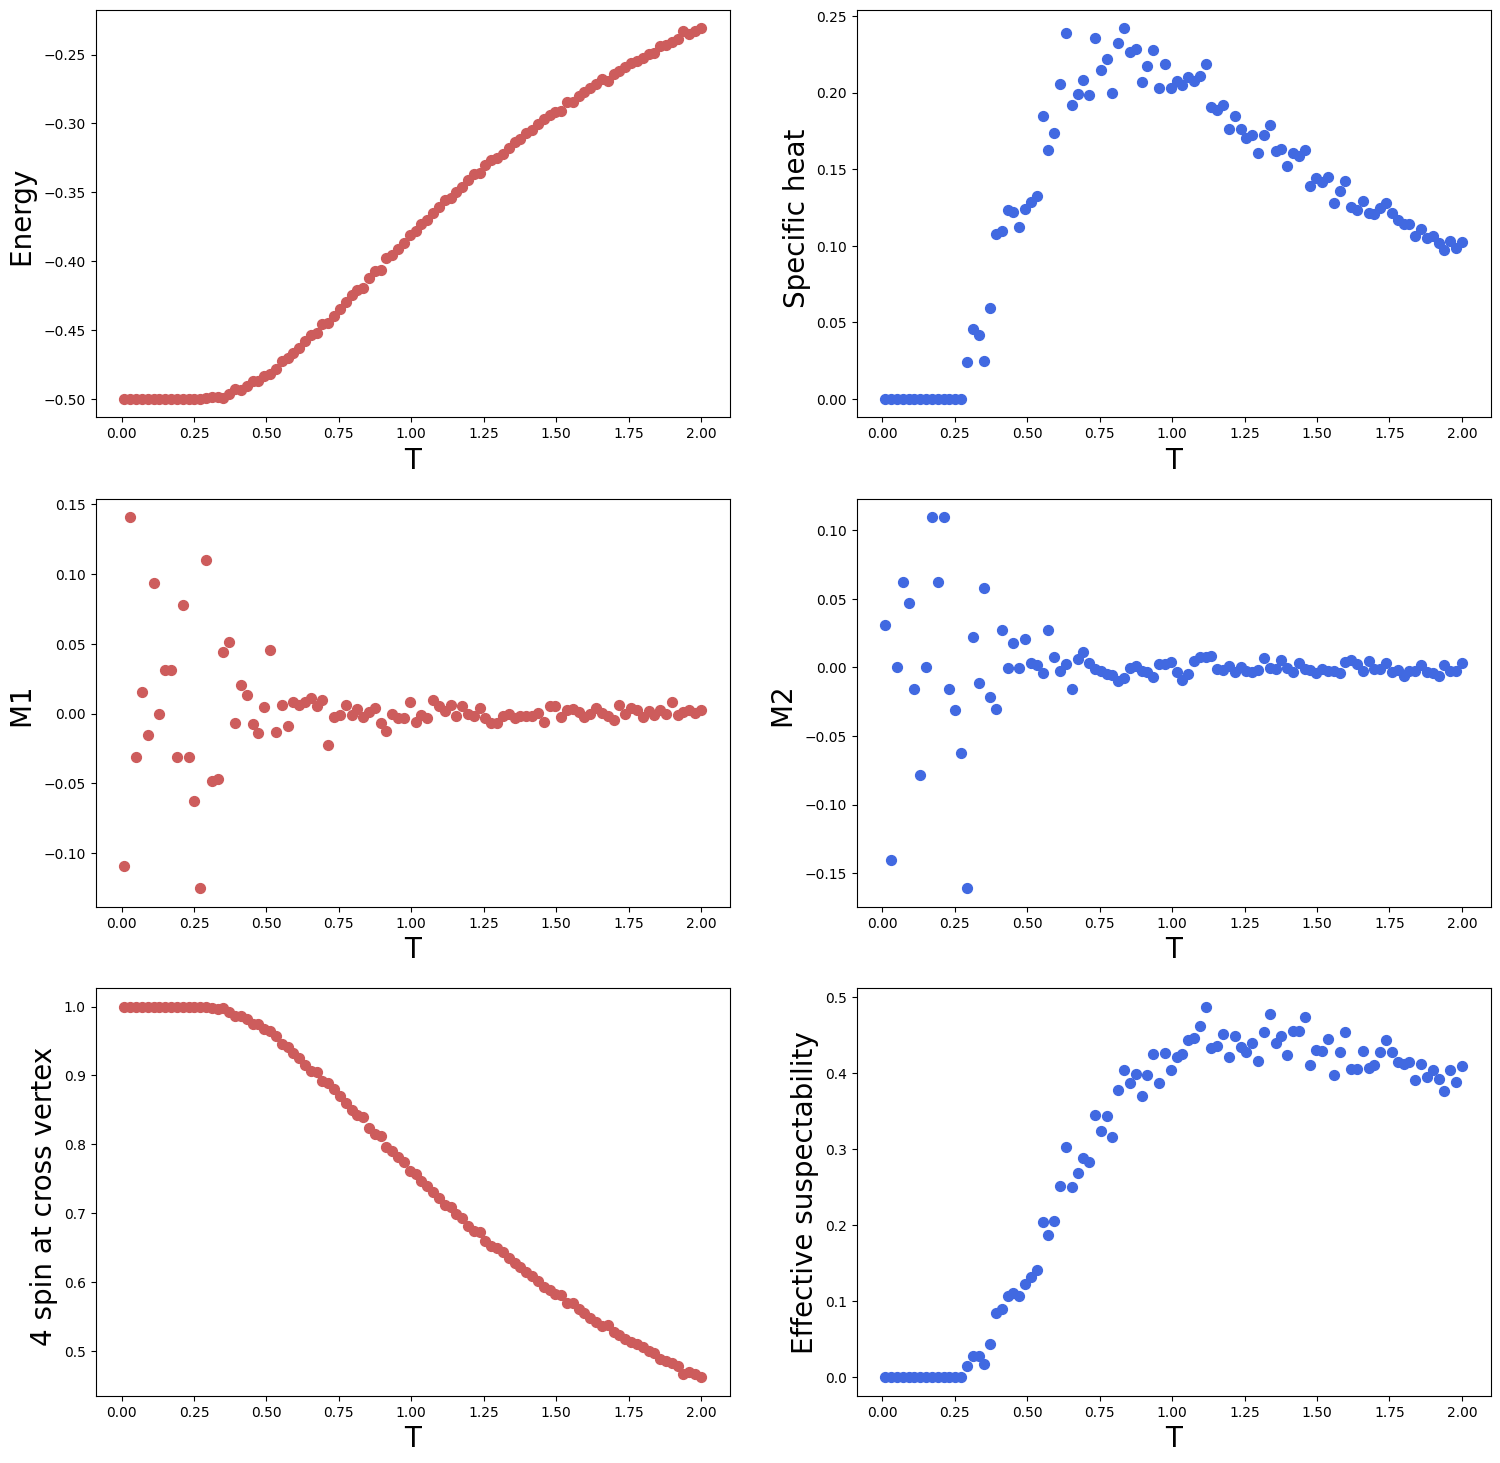

In [7]:
# beta = 0 and alpha=1
# 16x16 spins
f = plt.figure(figsize=(18, 18)); # plot the calculated values    

sp =  f.add_subplot(3, 2, 1);
plt.scatter(Tlist, Elist, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20); 
plt.ylabel("Energy ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 2);
plt.scatter(Tlist, Clist, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20); 
plt.ylabel("Specific heat ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 3);
plt.scatter(Tlist, M1list, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20); 
plt.ylabel("M1 ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 4);
plt.scatter(Tlist, M2list, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20);  
plt.ylabel("M2 ", fontsize=20);   plt.axis('tight'); 

sp =  f.add_subplot(3, 2, 5);
plt.scatter(Tlist, M4list, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20);  
plt.ylabel("4 spin at cross vertex ", fontsize=20);   plt.axis('tight'); 

sp =  f.add_subplot(3, 2, 6);
plt.scatter(Tlist, Xlist, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20);  
plt.ylabel("Effective suspectability", fontsize=20);   plt.axis('tight'); 

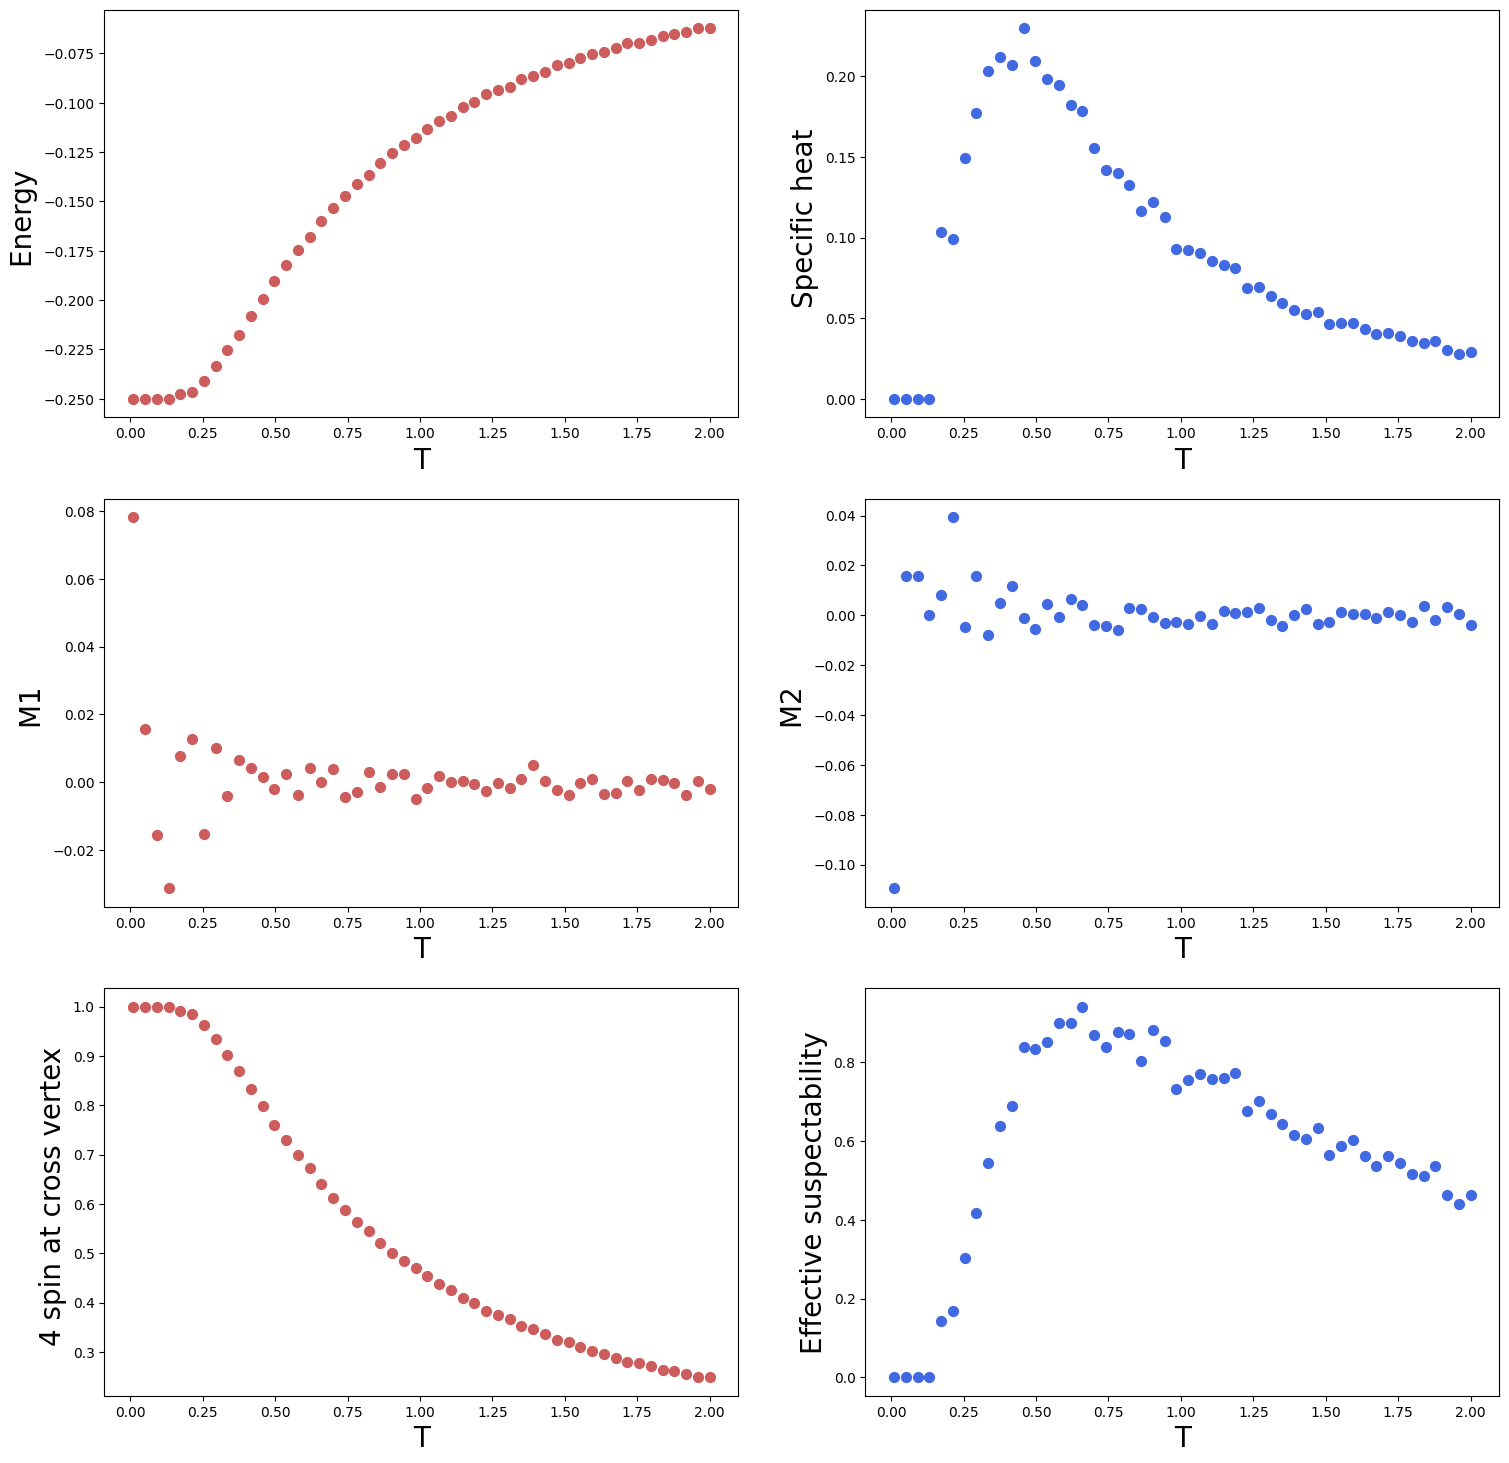

In [12]:
# beta = 5*10^(-11) and alpha=0.5
# 16x16 spins

f = plt.figure(figsize=(18, 18)); # plot the calculated values    

sp =  f.add_subplot(3, 2, 1);
plt.scatter(Tlist, Elist, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20); 
plt.ylabel("Energy ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 2);
plt.scatter(Tlist, Clist, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20); 
plt.ylabel("Specific heat ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 3);
plt.scatter(Tlist, M1list, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20); 
plt.ylabel("M1 ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 4);
plt.scatter(Tlist, M2list, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20);  
plt.ylabel("M2 ", fontsize=20);   plt.axis('tight'); 

sp =  f.add_subplot(3, 2, 5);
plt.scatter(Tlist, M4list, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20);  
plt.ylabel("4 spin at cross vertex ", fontsize=20);   plt.axis('tight'); 

sp =  f.add_subplot(3, 2, 6);
plt.scatter(Tlist, Xlist, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20);  
plt.ylabel("Effective suspectability", fontsize=20);   plt.axis('tight'); 

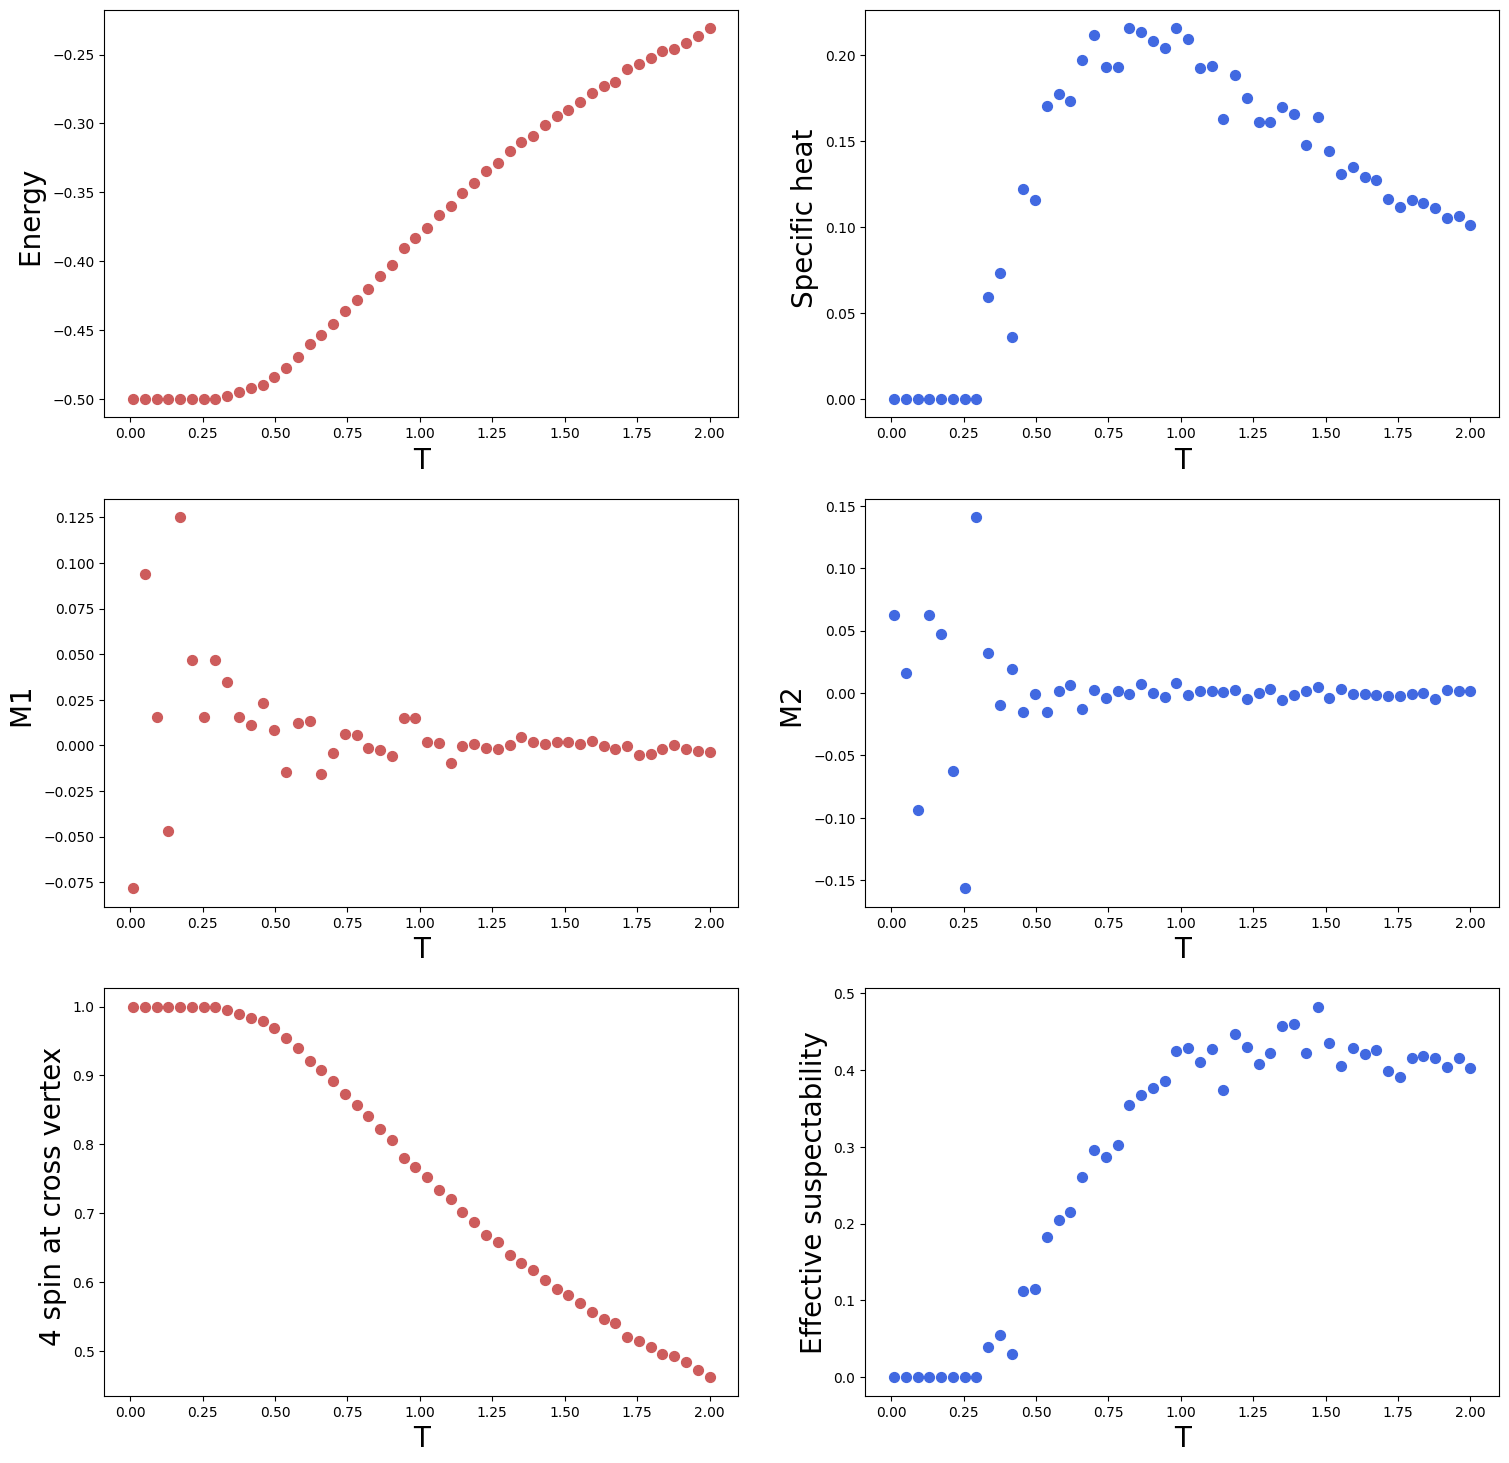

In [19]:
# beta = 10^(-10) and alpha=1
# 16x16 spins

f = plt.figure(figsize=(18, 18)); # plot the calculated values    

sp =  f.add_subplot(3, 2, 1);
plt.scatter(Tlist, Elist, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20); 
plt.ylabel("Energy ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 2);
plt.scatter(Tlist, Clist, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20); 
plt.ylabel("Specific heat ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 3);
plt.scatter(Tlist, M1list, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20); 
plt.ylabel("M1 ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 4);
plt.scatter(Tlist, M2list, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20);  
plt.ylabel("M2 ", fontsize=20);   plt.axis('tight'); 

sp =  f.add_subplot(3, 2, 5);
plt.scatter(Tlist, M4list, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20);  
plt.ylabel("4 spin at cross vertex ", fontsize=20);   plt.axis('tight'); 

sp =  f.add_subplot(3, 2, 6);
plt.scatter(Tlist, Xlist, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20);  
plt.ylabel("Effective suspectability", fontsize=20);   plt.axis('tight'); 

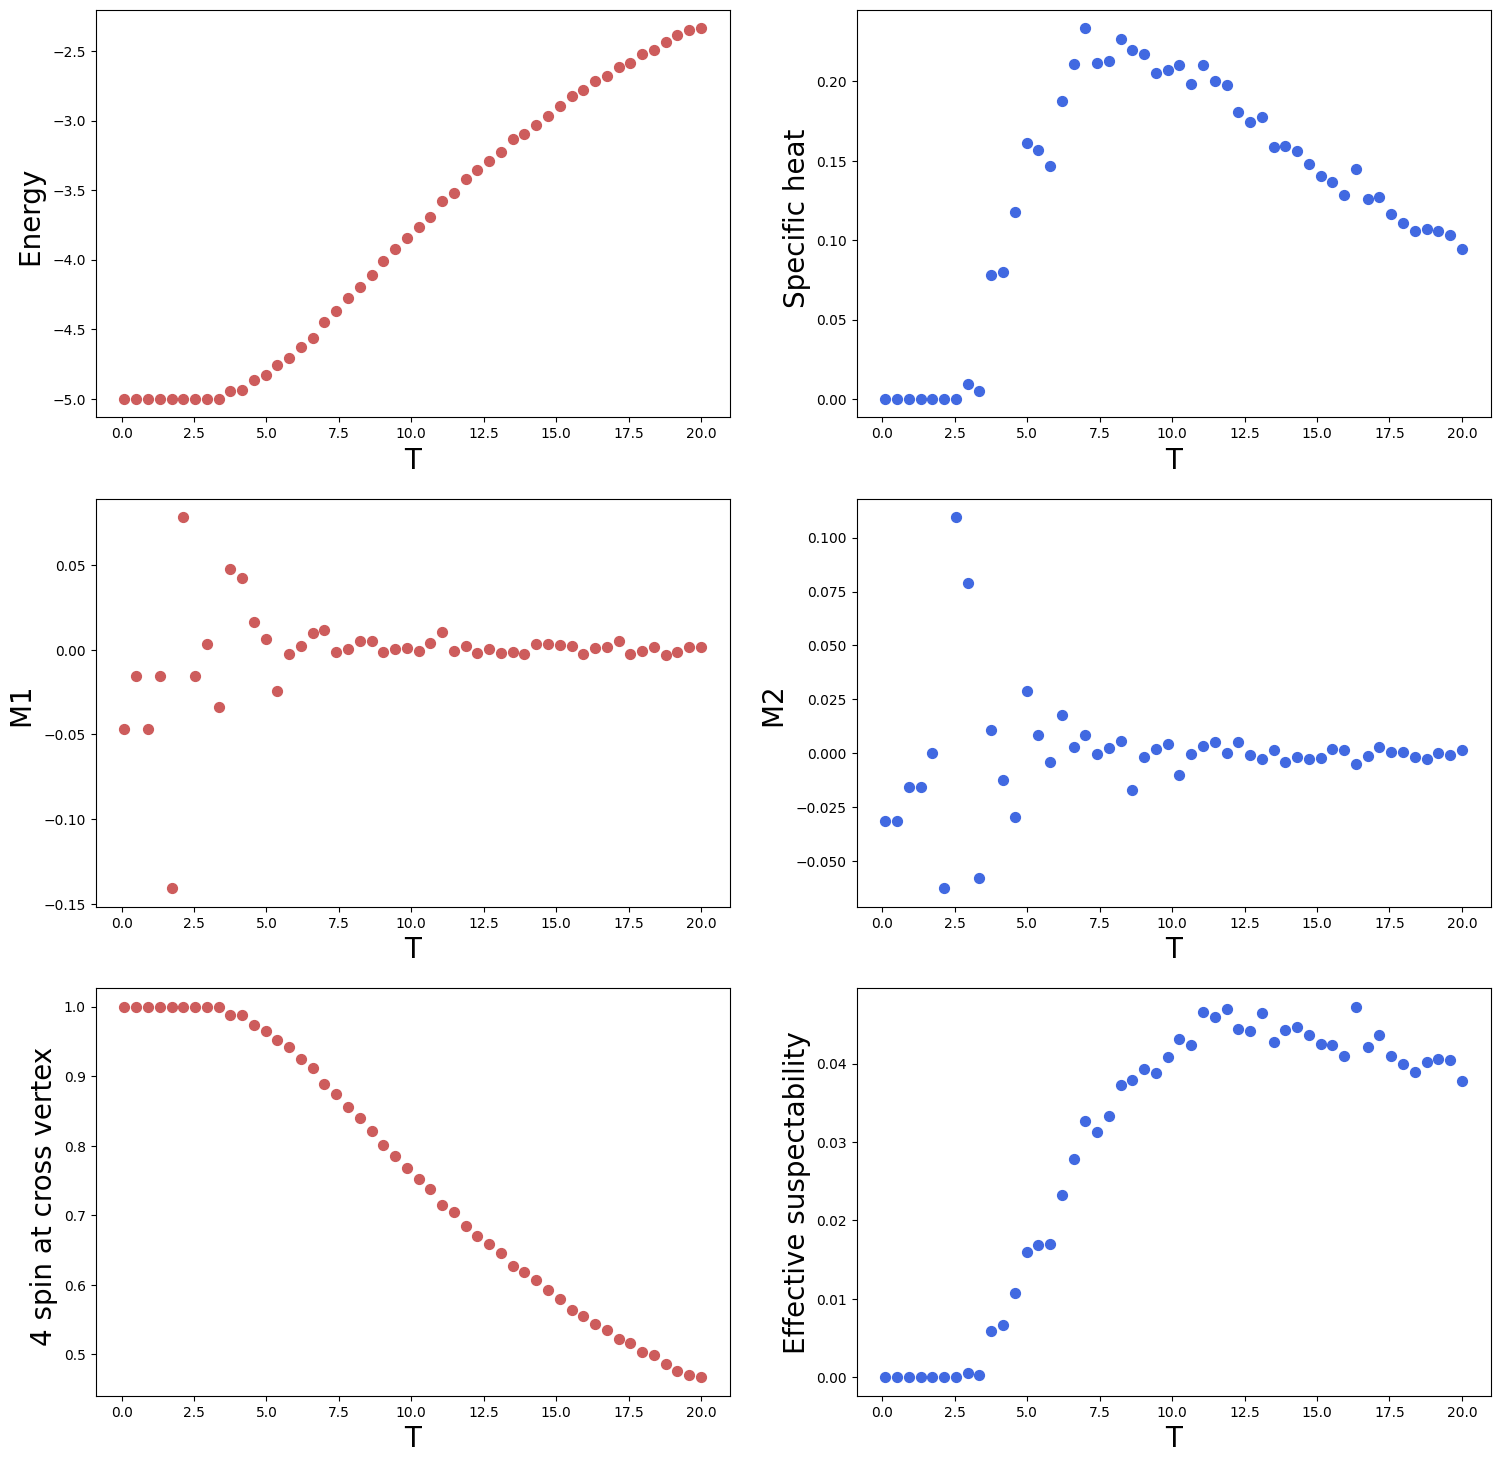

In [15]:
# beta = 10^(-9) and alpha=10
# 16x16 spins

f = plt.figure(figsize=(18, 18)); # plot the calculated values    

sp =  f.add_subplot(3, 2, 1);
plt.scatter(Tlist, Elist, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20); 
plt.ylabel("Energy ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 2);
plt.scatter(Tlist, Clist, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20); 
plt.ylabel("Specific heat ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 3);
plt.scatter(Tlist, M1list, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20); 
plt.ylabel("M1 ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 4);
plt.scatter(Tlist, M2list, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20);  
plt.ylabel("M2 ", fontsize=20);   plt.axis('tight'); 

sp =  f.add_subplot(3, 2, 5);
plt.scatter(Tlist, M4list, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20);  
plt.ylabel("4 spin at cross vertex ", fontsize=20);   plt.axis('tight'); 

sp =  f.add_subplot(3, 2, 6);
plt.scatter(Tlist, Xlist, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20);  
plt.ylabel("Effective suspectability", fontsize=20);   plt.axis('tight'); 

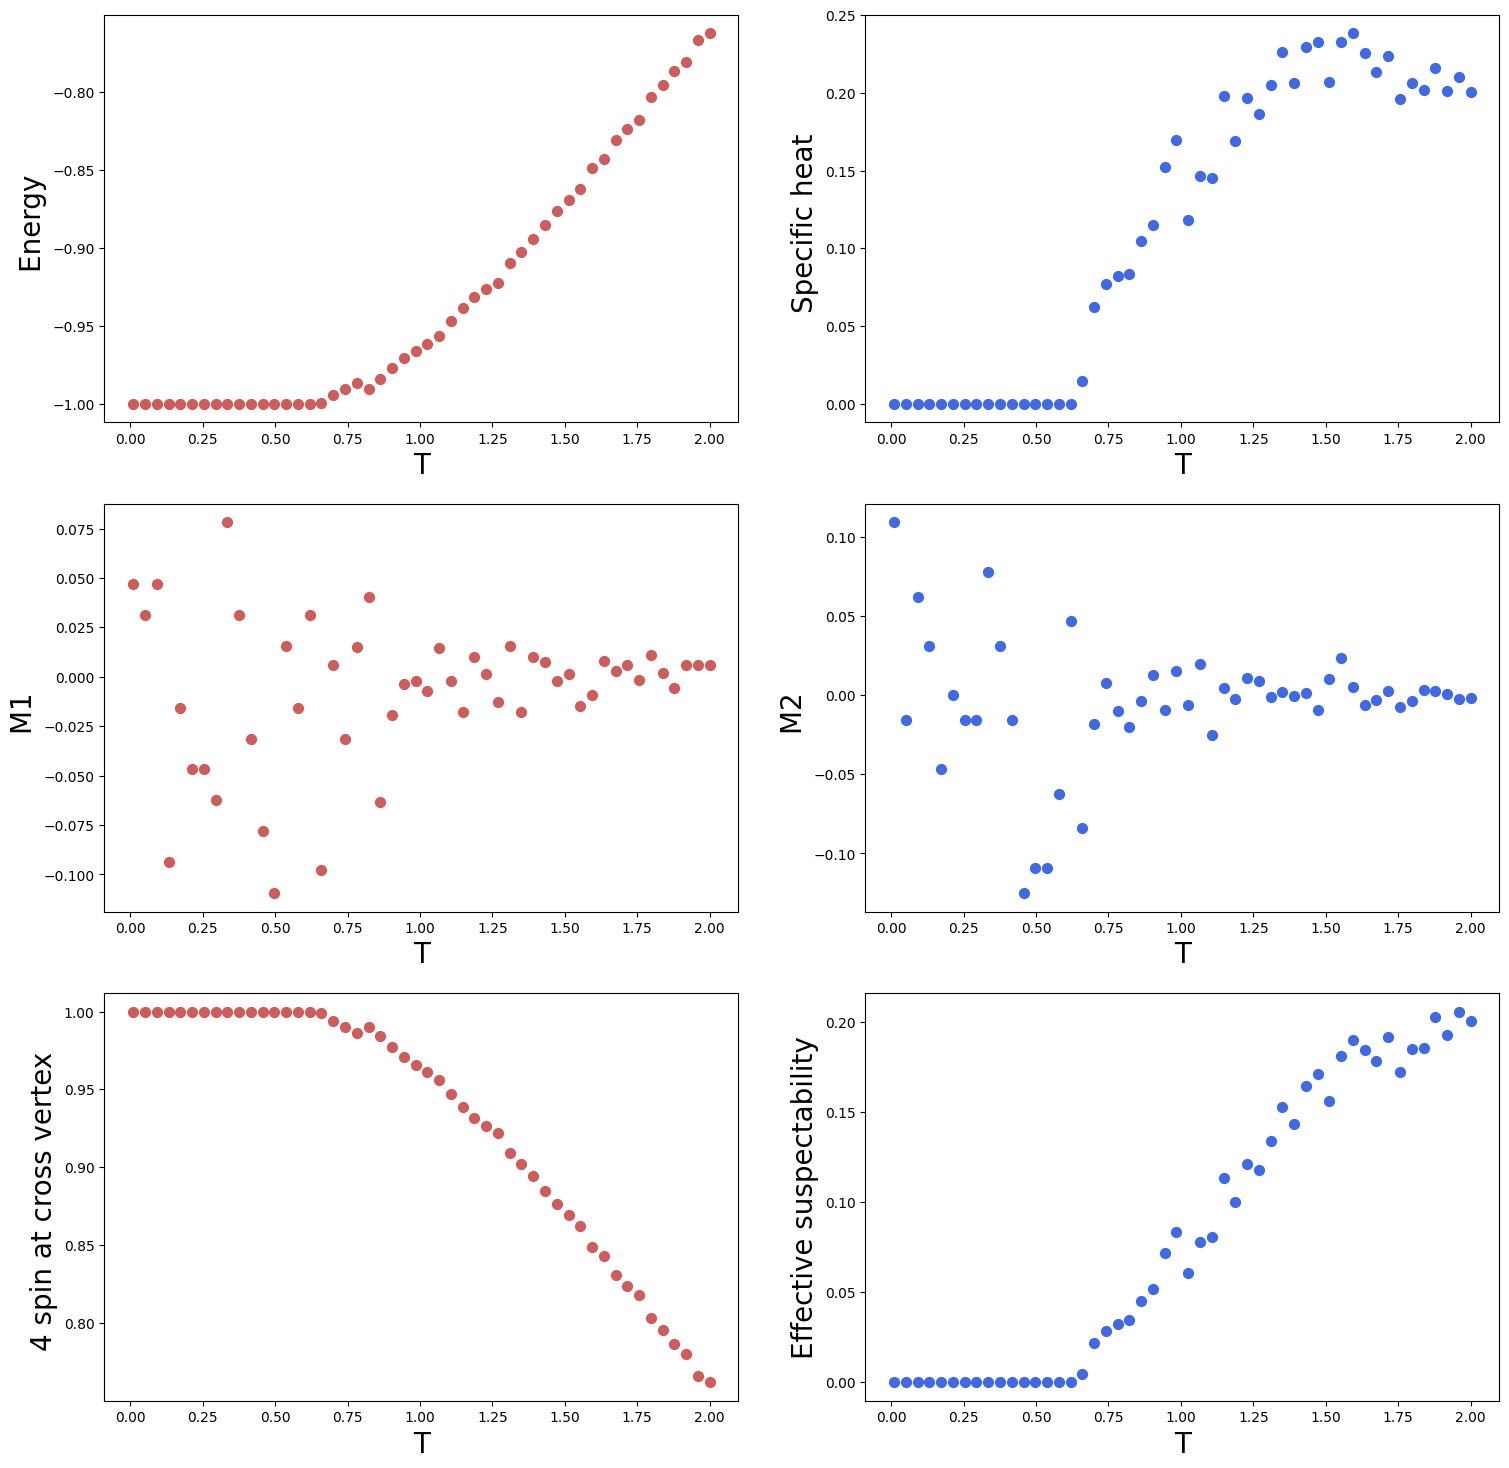

In [23]:
# beta = 10**(-5), alpha = 2
# Here, the ratio is much bigger, β/α = 5x10^(-6) >> 10^(-10)
# 16x16 spins

f = plt.figure(figsize=(18, 18)); # plot the calculated values    

sp =  f.add_subplot(3, 2, 1);
plt.scatter(Tlist, Elist, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20); 
plt.ylabel("Energy ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 2);
plt.scatter(Tlist, Clist, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20); 
plt.ylabel("Specific heat ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 3);
plt.scatter(Tlist, M1list, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20); 
plt.ylabel("M1 ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 4);
plt.scatter(Tlist, M2list, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20);  
plt.ylabel("M2 ", fontsize=20);   plt.axis('tight'); 

sp =  f.add_subplot(3, 2, 5);
plt.scatter(Tlist, M4list, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20);  
plt.ylabel("4 spin at cross vertex ", fontsize=20);   plt.axis('tight'); 

sp =  f.add_subplot(3, 2, 6);
plt.scatter(Tlist, Xlist, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20);  
plt.ylabel("Effective suspectability", fontsize=20);   plt.axis('tight'); 

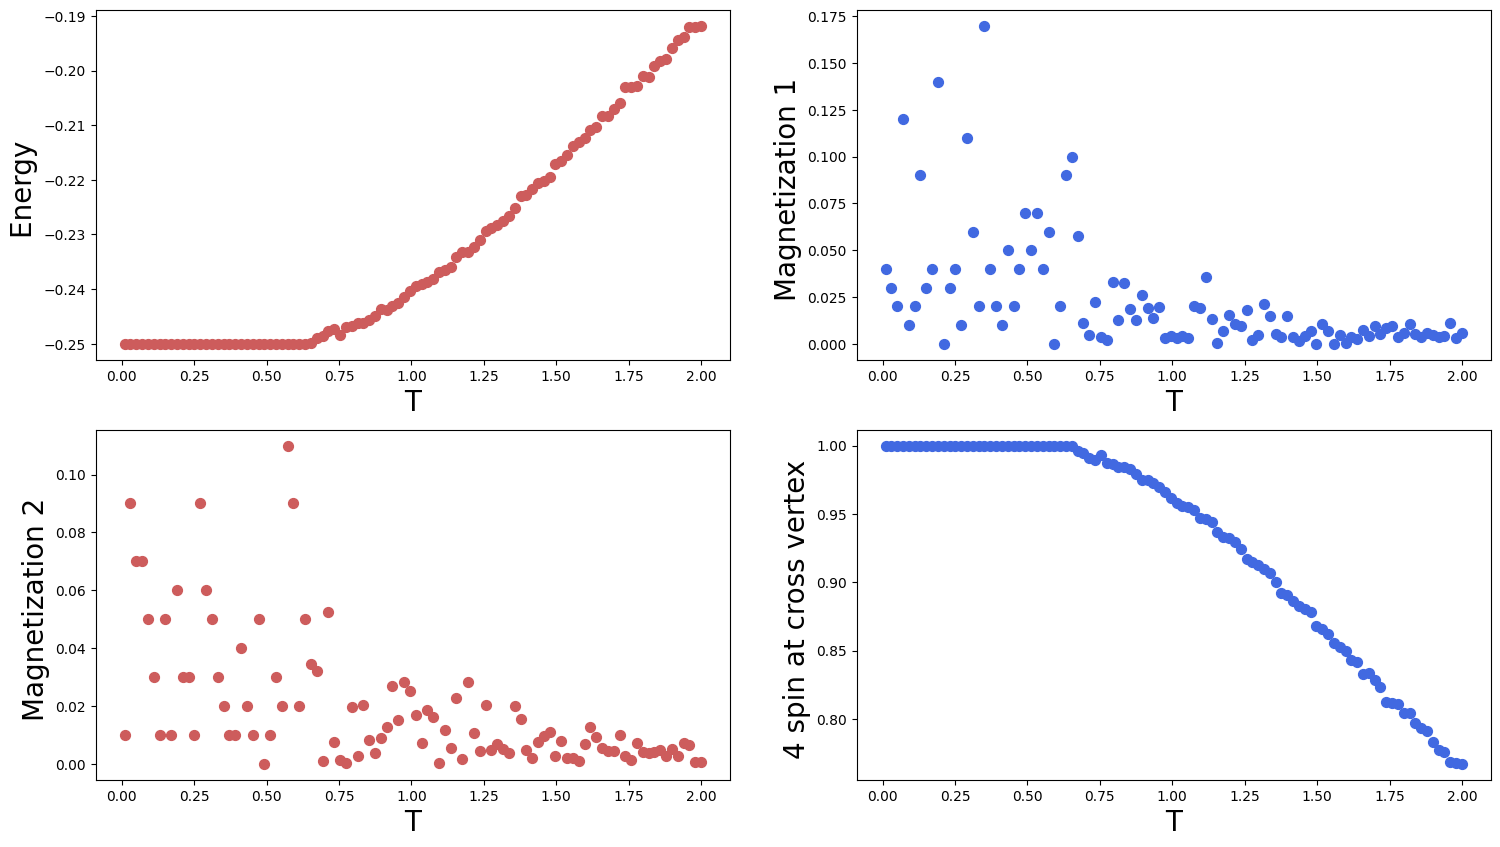

In [19]:
# beta = 10**(-5), alpha = 2
# 20x20 spins
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1);
plt.scatter(Tlist, Elist, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20); 
plt.ylabel("Energy ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 2);
plt.scatter(Tlist, abs(M1list), s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20); 
plt.ylabel("Magnetization 1 ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3);
plt.scatter(Tlist, abs(M2list), s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20);  
plt.ylabel("Magnetization 2 ", fontsize=20);   plt.axis('tight'); 

sp =  f.add_subplot(2, 2, 4);
plt.scatter(Tlist, M4list, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20);  
plt.ylabel("4 spin at cross vertex ", fontsize=20);   plt.axis('tight');  

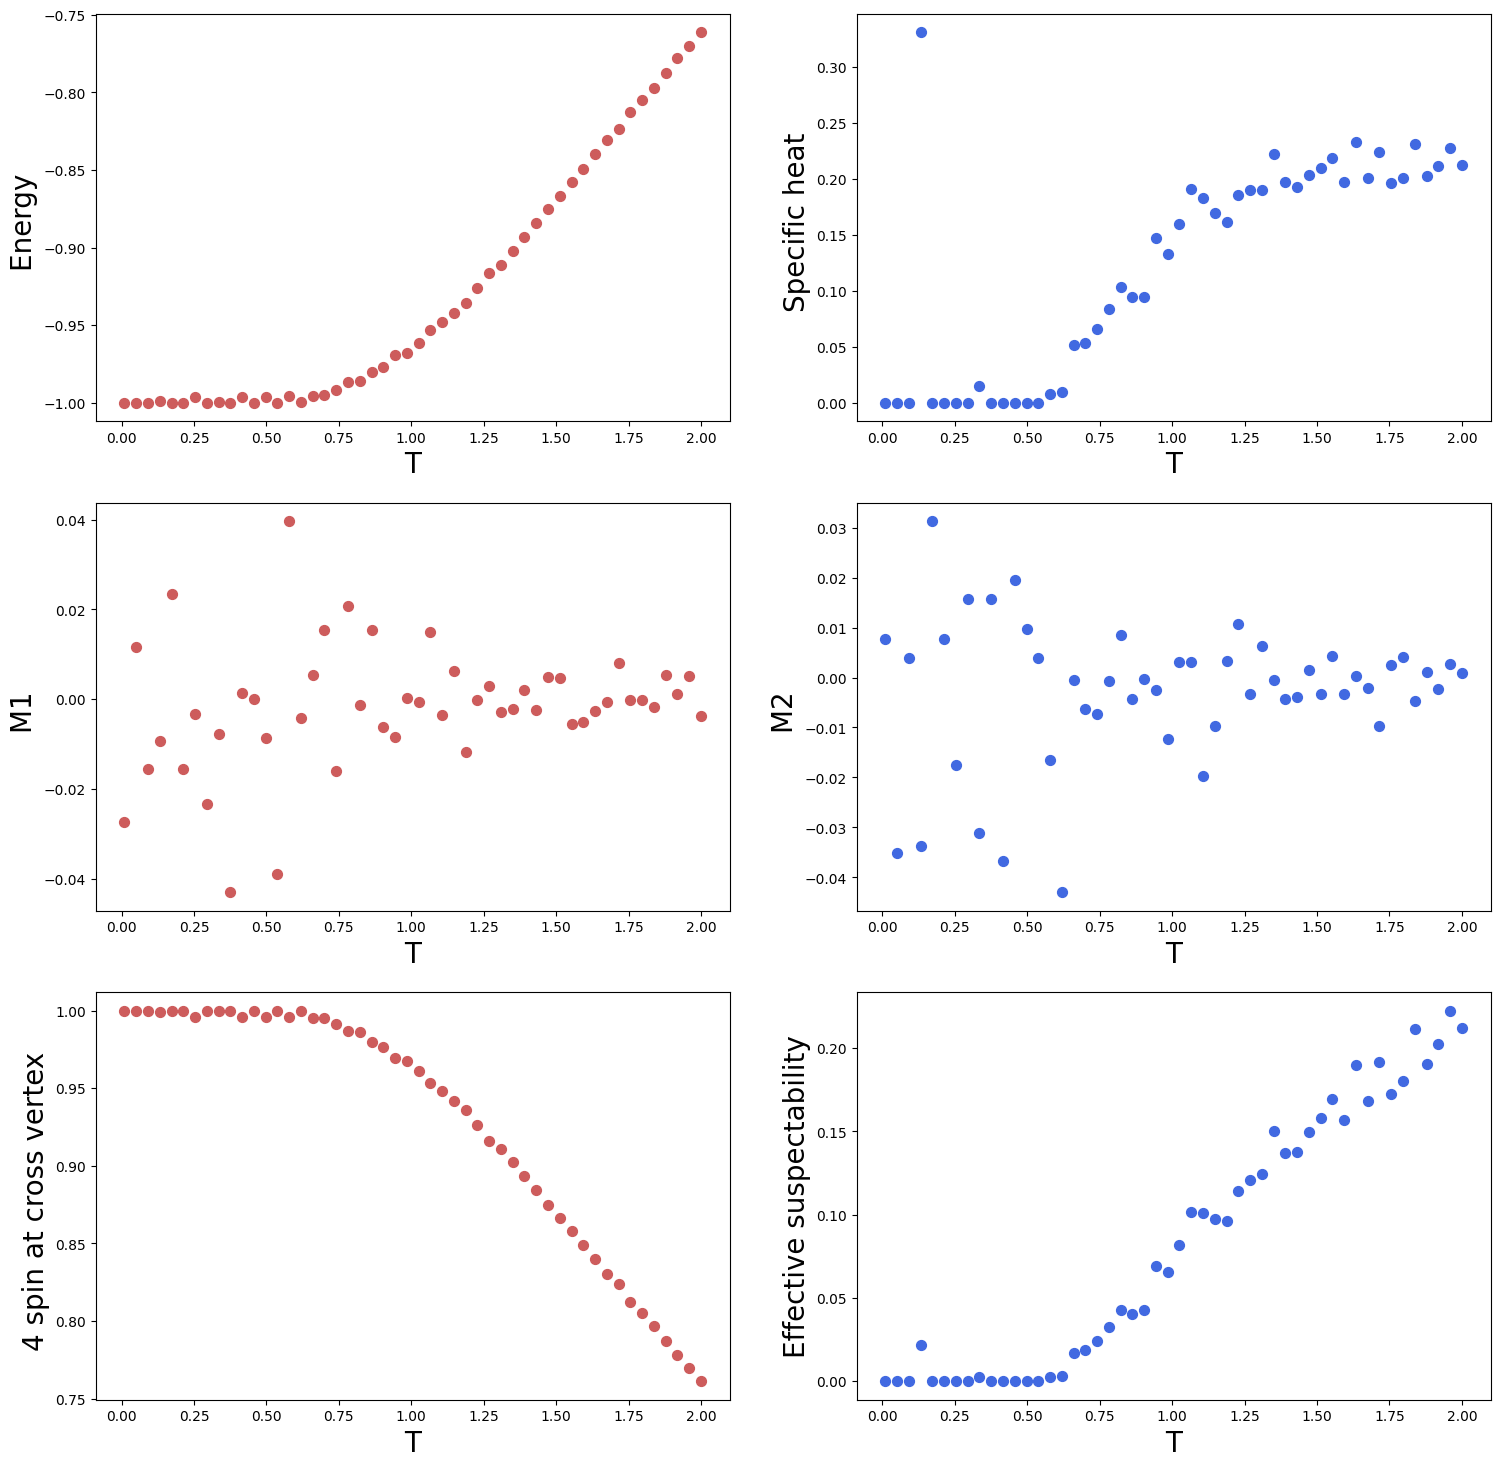

In [28]:
# beta = 10**(-5), alpha = 2
# 32x32 spins

f = plt.figure(figsize=(18, 18)); # plot the calculated values    

sp =  f.add_subplot(3, 2, 1);
plt.scatter(Tlist, Elist, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20); 
plt.ylabel("Energy ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 2);
plt.scatter(Tlist, Clist, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20); 
plt.ylabel("Specific heat ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 3);
plt.scatter(Tlist, M1list, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20); 
plt.ylabel("M1 ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(3, 2, 4);
plt.scatter(Tlist, M2list, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20);  
plt.ylabel("M2 ", fontsize=20);   plt.axis('tight'); 

sp =  f.add_subplot(3, 2, 5);
plt.scatter(Tlist, M4list, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20);  
plt.ylabel("4 spin at cross vertex ", fontsize=20);   plt.axis('tight'); 

sp =  f.add_subplot(3, 2, 6);
plt.scatter(Tlist, Xlist, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20);  
plt.ylabel("Effective suspectability", fontsize=20);   plt.axis('tight'); 

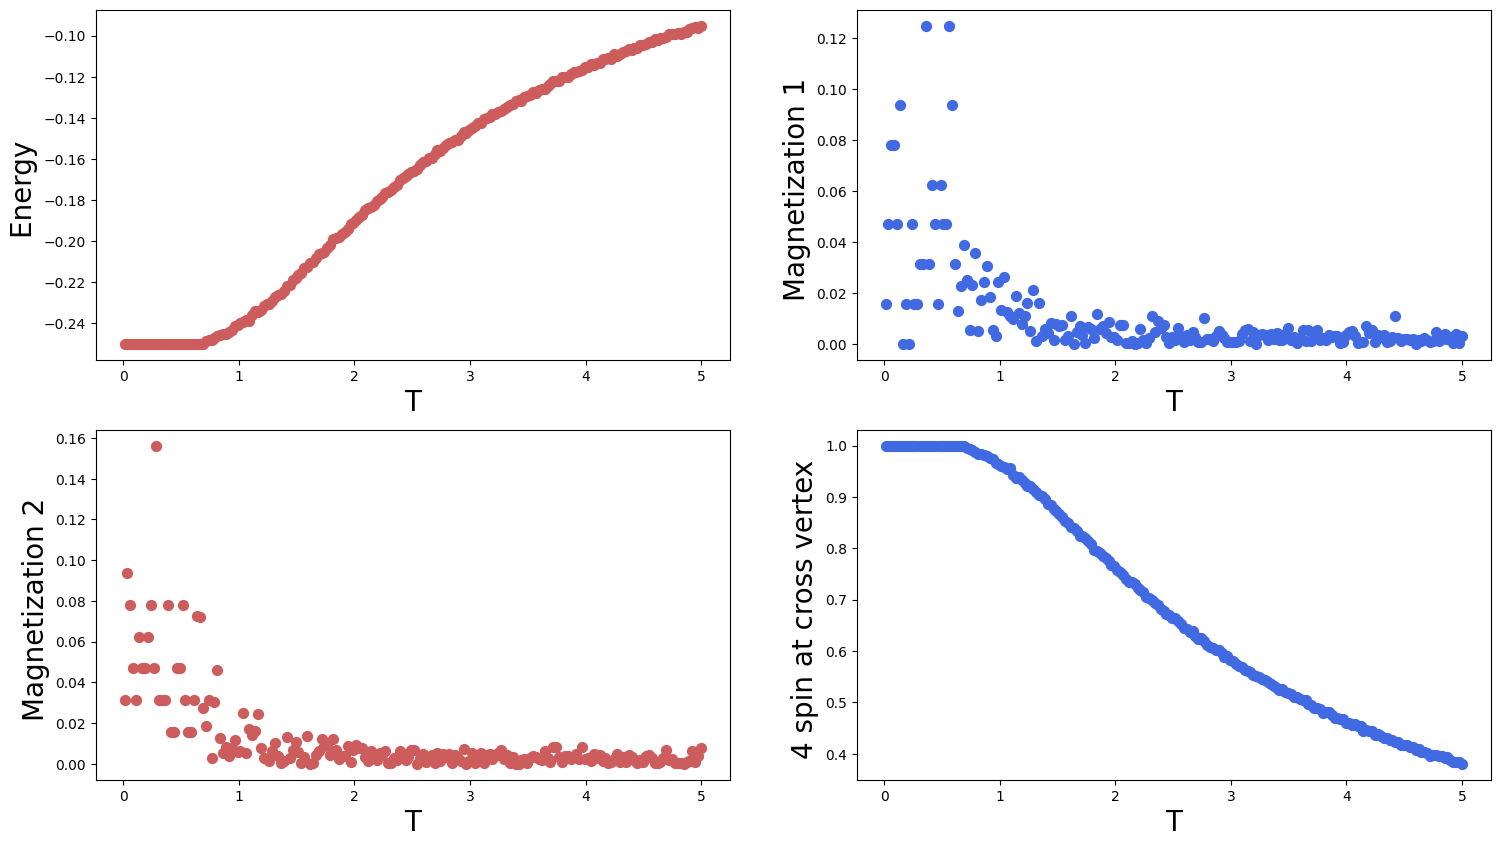

In [33]:
# beta = 10**(-5), alpha = 2
# 16x16 spins
# Larger range for T
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1);
plt.scatter(Tlist, Elist, s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20); 
plt.ylabel("Energy ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 2);
plt.scatter(Tlist, abs(M1list), s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20); 
plt.ylabel("Magnetization 1 ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3);
plt.scatter(Tlist, abs(M2list), s=50, marker='o', color='IndianRed')
plt.xlabel("T", fontsize=20);  
plt.ylabel("Magnetization 2 ", fontsize=20);   plt.axis('tight'); 

sp =  f.add_subplot(2, 2, 4);
plt.scatter(Tlist, M4list, s=50, marker='o', color='RoyalBlue')
plt.xlabel("T", fontsize=20);  
plt.ylabel("4 spin at cross vertex ", fontsize=20);   plt.axis('tight');  